In [56]:
# load libaries
import os
import SimpleITK as sitk
from skimage.transform import radon, iradon
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from perlin_noise import PerlinNoise
import torch
import torch.nn as nn
from torch.optim import Adam
from scipy.ndimage import rotate
import cv2
from skimage.restoration import denoise_tv_chambolle
import torch.nn.functional as F
import matplotlib.image as mpimg

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import the DIP repository, make sure to clone https://github.com/DmitryUlyanov/deep-image-prior
import sys
sys.path.append('C:/Users/Administrator/deep-image-prior')
from models import skip

In [29]:
def generate_sinogram_2d(image_2d, angles):
    # Get image dimensions
    rows, cols = image_2d.shape
    # Calculate the radius of the circle
    radius = min(rows, cols) // 2
    # Create a mask to zero out areas outside the circle
    Y, X = np.ogrid[:rows, :cols]
    center_y, center_x = rows / 2, cols / 2
    mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
    image_masked = image_2d * mask
    # Generate sinogram
    sinogram = radon(image_masked, theta=angles, circle=True)
    return sinogram


def add_poisson_noise(sinogram, scale=1e4):
    # Ensure there are no negative values (Poisson noise requires non-negative input)
    sinogram_clipped = np.clip(sinogram, 0, None)
    
    # Scale up the intensity values to approximate "photon counts"
    sinogram_scaled = sinogram_clipped * scale
    
    # Generate Poisson noise (random photon counts)
    sinogram_noisy_scaled = np.random.poisson(sinogram_scaled).astype(np.float32)
    
    # Scale back down to the original magnitude
    sinogram_noisy = sinogram_noisy_scaled / scale
    return sinogram_noisy


def backproject(sinogram, angles):
    reconstructed = np.zeros((sinogram.shape[1], sinogram.shape[1]))
    for i, angle in enumerate(angles):
        rotated_projection = rotate(np.tile(sinogram[i], (sinogram.shape[1], 1)).T, -angle, reshape=False)
        reconstructed += rotated_projection
    return reconstructed / len(angles)


def generate_sinogram(image, num_angles=180):
    angles = np.linspace(0, 180, num_angles, endpoint=False)
    sinogram = np.array([np.sum(rotate(image, angle, reshape=False), axis=0) for angle in angles])
    return sinogram, angles

In [30]:
def MLEM_reconstruction(sinogram, angles, reference_image, num_iterations=50):
    # Initialize the image with ones
    image_shape = (sinogram.shape[1], sinogram.shape[1])
    reconstructed = np.ones(image_shape, dtype=np.float32)
    psnr_values = []
    epsilon = 1e-6

    for iteration in range(num_iterations):
        # E-Step: Forward projection
        forward_projection = radon(reconstructed, theta=angles, circle=True)
        
        # Ensure matching shapes for division
        if forward_projection.shape != sinogram.shape:
            forward_projection = forward_projection[: sinogram.shape[0], :]
        
        # Compute the ratio
        ratio = sinogram / (forward_projection + epsilon)
        
        # M-Step: Backprojection of the ratio
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)
        
        # Update the reconstructed image
        reconstructed *= back_projection
        
        # Regularization to ensure non-negative image
        reconstructed = np.maximum(reconstructed, 0)
        
        # Compute PSNR
        psnr_value = cv2.PSNR(reference_image.astype(np.float32), reconstructed.astype(np.float32))
        psnr_values.append(psnr_value)
    
    return reconstructed, psnr_values

def plot_psnr(psnr_values):
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(psnr_values) + 1), psnr_values,  linestyle='-')
    plt.xlabel("Number of Iterations")
    plt.ylabel("PSNR (dB)")
    plt.title("PSNR vs. Number of Iterations for MLEM Reconstruction")
    plt.grid()
    plt.show()

In [31]:
## Dicom reader
def load_dicom_series(folder_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
    if not dicom_names:
        raise ValueError(f"No DICOM files found in {folder_path}")
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def normalize_image(image):
    img_array = sitk.GetArrayFromImage(image).astype(np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    if img_max - img_min < 1e-5:
        return np.zeros_like(img_array)
    else:
        return (img_array - img_min) / (img_max - img_min)

In [32]:
## Image registration
def register_pet_ct(ct_image, pet_image, mode="upsample_PET"):
    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()

    # Set multi-resolution pyramid strategy
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Set registration metric
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    # Set transformation type (rigid transformation)
    initial_transform = sitk.CenteredTransformInitializer(
        ct_image,
        pet_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Set optimizer
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0,
                                                      numberOfIterations=100,
                                                      convergenceMinimumValue=1e-6,
                                                      convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Set interpolation method
    registration_method.SetInterpolator(sitk.sitkLinear)

    try:
        final_transform = registration_method.Execute(sitk.Cast(ct_image, sitk.sitkFloat32),
                                                      sitk.Cast(pet_image, sitk.sitkFloat32))
        print("Optimizer Converged:", registration_method.GetOptimizerStopConditionDescription())
        print("Final Metric Value:", registration_method.GetMetricValue())
    except Exception as e:
        print(f"\nRegistration failed: {e}")
        raise e

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(final_transform)

    if mode == "upsample_PET":
        resampler.SetReferenceImage(ct_image)
        pet_resampled = resampler.Execute(pet_image)
        print("Resampling completed.")
        return ct_image, pet_resampled

    elif mode == "downsample_CT":
        resampler.SetReferenceImage(pet_image)
        ct_resampled = resampler.Execute(ct_image)
        print("Resampling completed.")
        return ct_resampled, pet_image

    else:
        raise ValueError("Invalid mode selection, mode should be 'upsample_PET' or 'downsample_CT'")

In [33]:
# Design for Bowsher prior Filter 
def apply_bayesian_filter(image_2d, sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001):
    # Compute the Bayesian kernel (Bowsher-like prior)
    kernel = compute_bowsher_kernel_2d(image_2d, zeta=zeta, rho=rho, alpha=alpha)
    filtered_image = image_2d * kernel
    return filtered_image

def compute_kernel_2d(ct_2d, sigma=1.0):
    # Compute the gradient of the CT image
    gradient_x = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_y = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Design a bilateral kernel, assigning lower weights to edges
    kernel = np.exp(- (gradient_magnitude ** 2))
    return kernel

def psi(u, zeta=0.5, rho=0.01):
    return (np.arctan((zeta - u) / rho) / np.pi) + 0.5

def Tq_linear(value):
    return value

def compute_bowsher_kernel_2d(
    ct_image_2d, 
    zeta=0.5, 
    rho=0.01, 
    Tq_func=Tq_linear, 
    epsilon=1e-6,
    alpha = 0.001
):
    # Offsets for the 8 neighbors in (dy, dx)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    
    H, W = ct_image_2d.shape
    weights_2d = np.zeros((H, W, len(neighbor_offsets)), dtype=np.float32)

    # Pre-compute Tq for the entire image to avoid repeated calls
    transformed_ct = Tq_func(ct_image_2d)

    # For each pixel, we need M_j = max|Tq(mu_j) - Tq(mu_k)| over neighbors
    M_array = np.zeros((H, W), dtype=np.float32)

    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            diffs = []
            for dy, dx in neighbor_offsets:
                ny, nx = y + dy, x + dx
                if 0 <= ny < H and 0 <= nx < W:
                    neighbor_val = transformed_ct[ny, nx]
                    diffs.append(abs(central_val - neighbor_val))
            if len(diffs) > 0:
                M_array[y, x] = max(diffs)
            else:
                M_array[y, x] = 0.0

    # Compute the actual weights for each neighbor
    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            Mj = M_array[y, x]
            
            for n_idx, (dy, dx) in enumerate(neighbor_offsets):
                ny, nx = y + dy, x + dx
                if not (0 <= ny < H and 0 <= nx < W):
                    # Out of bounds, weight = 0
                    weights_2d[y, x, n_idx] = 0.0
                    continue
                
                neighbor_val = transformed_ct[ny, nx]
                Mk = M_array[ny, nx]
                
                denom = (Mj + Mk) / 2.0
                denom = denom if denom > epsilon else epsilon
                
                diff = abs(central_val - neighbor_val)
                u_jk = diff / denom
                
                w_jk = psi(u_jk, zeta=zeta, rho=rho)
                weights_2d[y, x, n_idx] = w_jk

    kernel = np.sum(weights_2d, axis=-1)
    kernel = np.exp(alpha * kernel) 
    return kernel

In [34]:
def project(image, angles):
    return radon(image, theta=angles, circle=True)

def backproject(sinogram, angles):
     if isinstance(sinogram, torch.Tensor):
        sinogram = sinogram.cpu().numpy()
     return iradon(sinogram, theta=angles, circle=True)


def apply_filter(image, method="bilateral", sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001, ct_prior=None):

    image_np = image.detach().cpu().numpy() 

    if method == "bilateral":
        filtered_image = cv2.bilateralFilter(image_np.astype(np.float32), d=9, sigmaColor=sigma*50, sigmaSpace=sigma*50)
    
    elif method == "anisotropic":
        filtered_image = denoise_tv_chambolle(image_np, weight=sigma)
    
    elif method == "gaussian":
        filtered_image = gaussian_filter(image_np, sigma=sigma)
    
    elif method == "bayesian":
        filtered_image = apply_bayesian_filter(image_np, sigma=sigma, zeta=zeta, rho=rho, alpha=alpha)
    
    elif method == "gradient":
        if ct_prior is None:
            raise ValueError("CT prior required for gradient-based kernel filtering.")

        ct_prior_np = ct_prior.squeeze().detach().cpu().numpy()
        kernel = compute_kernel_2d(ct_prior_np, sigma=sigma)  # Compute anatomical gradient kernel
        filtered_image = image_np * kernel  # Weight input image by anatomical kernel

    else:
        raise ValueError("Invalid method. Choose 'bilateral', 'anisotropic', 'gaussian', 'bayesian', or 'gradient'.")

    return torch.tensor(filtered_image, dtype=torch.float32).to(image.device)


def KEM_step(image, sinogram, angles, kernel_size, sigma=1.0, filter_method="bilateral", ct_prior=None, num_em_iterations=5):
    device = image.device
    updated_image = image.clone()  # Ensure we iterate on a copy

    for _ in range(num_em_iterations):  # Iterate multiple EM steps
        # Step 1: Forward project
        forward_projection = project(updated_image.squeeze().detach().cpu().numpy(), angles)
        forward_projection = torch.tensor(forward_projection, dtype=torch.float32).to(device)

        # Step 2: Compute ratio
        ratio = sinogram / (forward_projection + 1e-8)
        ratio = ratio.clamp(min=0, max=10)  # Prevent extreme values

        # Step 3: Backproject ratio update
        back_projection = backproject(ratio.cpu().numpy(), angles)
        back_projection = torch.tensor(back_projection, dtype=torch.float32).to(device)

        # Step 4: Apply filtering
        smoothed_image = apply_filter(updated_image.squeeze(), method=filter_method, sigma=sigma, ct_prior=ct_prior)

        # Step 5: Update estimate
        updated_image = smoothed_image * back_projection
        updated_image = updated_image / updated_image.max()  # Normalize

    return updated_image.unsqueeze(0).unsqueeze(0)



In [35]:
def DIP_to_KEM_notfixed(sinogram, angles, ct_prior, kernel_size, num_iterations=10, dip_iterations=100, sigma=1.0, filter="bilateral"):
    device = torch.device("cpu")  # Use CPU for computation

    # Initialize image with FBP reconstruction
    initial_image = backproject(sinogram, angles)
    current_image = torch.tensor(initial_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Normalize and resize CT prior
    ct_prior = ct_prior.clone().detach().float().unsqueeze(0).unsqueeze(0).to(device)
    ct_prior = (ct_prior - ct_prior.min()) / (ct_prior.max() - ct_prior.min())  # Normalize to [0,1]

    if ct_prior.shape != current_image.shape:
        ct_prior = torch.nn.functional.interpolate(ct_prior, size=current_image.shape[2:], mode="bilinear", align_corners=False)

    # Define DIP network
    input_depth = 2  # one channel for noise or FBP, one for CT prior
    net = skip(
        input_depth, 1,  # Single-channel grayscale output
        num_channels_down=[16, 32, 64, 128, 128],  # Downsampling layers
        num_channels_up=[16, 32, 64, 128, 128],  # Upsampling layers
        num_channels_skip=[4, 4, 4, 4, 4],  # Skip connections to maintain spatial info
        upsample_mode='bilinear',  # Interpolation mode for upsampling
        need_sigmoid=True,  # Sigmoid activation for output (keeps values in [0,1])
        need_bias=True,  # Adds bias terms
        pad='reflection',  # Padding type (reflection padding helps prevent artifacts)
        act_fun='LeakyReLU'  # Activation function in convolution layers
    ).to(device)

    # Define optimizer for DIP
    optimizer = torch.optim.Adam(net.parameters(), lr=0.008)
    mse_loss = torch.nn.MSELoss()

    # DIP input (multi-channel: noise + CT), FBP + CT is best
    multi_channel_input = torch.cat((current_image, ct_prior), dim=1)

    for i in range(num_iterations):
        # Perform DIP first (in image-space regularization)
        for _ in range(dip_iterations):
            optimizer.zero_grad()
            dip_output = net(multi_channel_input)
            
            # Use KEM to enforce fidelity (data space to image space)
            kem_output = KEM_step(dip_output, sinogram, angles, kernel_size, sigma, filter_method=filter, ct_prior=ct_prior)

            # Combine DIP and KEM outputs
            fidelity_loss = mse_loss(dip_output, kem_output)

            # Convert tensors to NumPy for SSIM calculation
            dip_np = dip_output.squeeze().detach().cpu().numpy()
            ct_np = ct_prior.squeeze().detach().cpu().numpy()

            # Structural similarity loss (align with CT)
            ssim_loss = 1 - ssim(dip_np, ct_np, data_range=1.0)
            total_loss = fidelity_loss + 0.1 * ssim_loss  # Weighted loss function
            total_loss.backward()

            optimizer.step()

        # Update current_image with the DIP output and apply KEM next
        current_image = dip_output.detach()

        # Perform KEM (data-space regularization)
        kem_output = KEM_step(current_image, sinogram, angles, kernel_size, sigma, filter_method=filter, ct_prior=ct_prior)
        current_image = kem_output.clone()  # Update current image with KEM result

    # Convert final image to NumPy array for visualization
    final_image = current_image.squeeze().detach().cpu().numpy()

    return final_image

In [36]:
def DIP_to_KEM(sinogram, angles, ct_prior, kernel_size, num_iterations=10, dip_iterations=100, sigma=1.0, filter="bilateral"):
    device = torch.device("cpu")  

    # Initialize image with FBP reconstruction
    initial_image = backproject(sinogram, angles)
    current_image = torch.tensor(initial_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Normalize and resize CT prior
    ct_prior = ct_prior.clone().detach().float().unsqueeze(0).unsqueeze(0).to(device)
    ct_prior = (ct_prior - ct_prior.min()) / (ct_prior.max() - ct_prior.min())

    if ct_prior.shape != current_image.shape:
        ct_prior = torch.nn.functional.interpolate(ct_prior, size=current_image.shape[2:], mode="bilinear", align_corners=False)

    # Define DIP network
    input_depth = 2
    net = skip(
        input_depth, 1,  
        num_channels_down=[16, 32, 64, 128, 128],
        num_channels_up=[16, 32, 64, 128, 128],
        num_channels_skip=[4, 4, 4, 4, 4],
        upsample_mode='bilinear',
        need_sigmoid=True,
        need_bias=True,
        pad='reflection',
        act_fun='LeakyReLU'
    ).to(device)

    # Define optimizer for DIP
    optimizer = torch.optim.Adam(net.parameters(), lr=0.008)
    mse_loss = torch.nn.MSELoss()

    # DIP input (multi-channel: noise + CT prior)
    multi_channel_input = torch.cat((current_image, ct_prior), dim=1)

    for i in range(num_iterations):
        # Perform DIP (image-space regularization)
        for _ in range(dip_iterations):
            optimizer.zero_grad()
            dip_output = net(multi_channel_input)

            # Apply KEM for data-space fidelity
            kem_output = KEM_step(dip_output, sinogram, angles, kernel_size, sigma, filter_method=filter, ct_prior=ct_prior, num_em_iterations=5)

            # Compute loss
            fidelity_loss = mse_loss(dip_output, kem_output)

            # Convert tensors for SSIM
            dip_np = dip_output.squeeze().detach().cpu().numpy()
            ct_np = ct_prior.squeeze().detach().cpu().numpy()

            # Structural similarity loss (align with CT)
            ssim_loss = 1 - ssim(dip_np, ct_np, data_range=1.0)
            total_loss = fidelity_loss + 0.1 * ssim_loss
            total_loss.backward()
            optimizer.step()

        # Update current image
        current_image = dip_output.detach()

        # **Perform iterative KEM after DIP update**
        for _ in range(3):  # Run a few KEM iterations after each DIP cycle
            current_image = KEM_step(current_image, sinogram, angles, kernel_size, sigma, filter_method=filter, ct_prior=ct_prior, num_em_iterations=5)

    return current_image.squeeze().detach().cpu().numpy()


In [37]:
# Evaluation
def evaluate_reconstruction(ground_truth, reconstructed):
    mse_val = mse(ground_truth, reconstructed)
    rmse_val = np.sqrt(mse_val)
    psnr_val = cv2.PSNR(ground_truth.astype(np.float32), reconstructed.astype(np.float32))
    ssim_val = ssim(ground_truth, reconstructed, data_range=ground_truth.max() - ground_truth.min())

    return mse_val, psnr_val, ssim_val, rmse_val

In [38]:
def load_images(ct_folder_path, pet_folder_path):
    # Load images
    print("Loading CT image...")
    ct_image = load_dicom_series(ct_folder_path)
    print("Loading PET image...")
    pet_image = load_dicom_series(pet_folder_path)

    # Print image information
    def print_image_info(name, image):
     print(f"\n{name} Image Information:")
     print(f"  Size: {image.GetSize()}")
     print(f"  Spacing: {image.GetSpacing()}")
     print(f"  Origin: {image.GetOrigin()}")
     print(f"  Direction: {image.GetDirection()}")
     print(f"  Dimension: {image.GetDimension()}")

    print_image_info("CT", ct_image)
    print_image_info("PET", pet_image)

    # Ensure both are 3D images
    if ct_image.GetDimension() != 3 or pet_image.GetDimension() != 3:
        raise ValueError("Both CT and PET images must be 3D.")

    # Ensure both are float32
    ct_image = sitk.Cast(ct_image, sitk.sitkFloat32)
    pet_image = sitk.Cast(pet_image, sitk.sitkFloat32)

    #mode = "upsample_PET"
    mode = "downsample_CT"
    ct_image_resampled, pet_image_resampled = register_pet_ct(ct_image, pet_image, mode=mode)

    # ================== 3) Select Middle Slice and Generate Sinogram ==================

    # Select middle slice
    ct_array = sitk.GetArrayFromImage(ct_image_resampled)  # shape: [slices, height, width]
    pet_array = sitk.GetArrayFromImage(pet_image_resampled)  # shape: [slices, height, width]

    middle_slice_idx = ct_array.shape[0] // 2
    ct_slice = ct_array[middle_slice_idx, :, :]
    pet_slice = pet_array[middle_slice_idx, :, :]

    # Normalize
    ct_norm = normalize_image(ct_image_resampled)
    pet_norm = normalize_image(pet_image_resampled)
    ct_slice_norm = ct_norm[middle_slice_idx, :, :]
    pet_slice_norm = pet_norm[middle_slice_idx, :, :]
    initial_kernel_size = ct_slice_norm

    # Generate sinogram
    angles = np.linspace(0., 180., max(ct_slice.shape), endpoint=False)
    pet_sinogram = generate_sinogram_2d(pet_slice_norm, angles)
    pet_sinogram = add_poisson_noise(pet_sinogram, scale=1) # decrease the number to increase the noise, 0.1 was extremly noisy 

    return pet_sinogram, ct_slice, ct_slice_norm, initial_kernel_size, pet_slice, pet_slice_norm, angles


In [39]:
# Load an example image DICOM
ct_folder_path = r"C:\Users\Administrator\OneDrive - stud.hs-mannheim.de\Dokumente\PCC3\NIH\PET\CT_1.3.6.1.4.1.14519.5.2.1.7009.2403.798861112144623421423086363370"
pet_folder_path = r"C:\Users\Administrator\OneDrive - stud.hs-mannheim.de\Dokumente\PCC3\NIH\PET\PT_1.3.6.1.4.1.14519.5.2.1.7009.2403.291916523874874486349020167447"


In [40]:
pet_sinogram, ct_slice, ct_slice_norm, initial_kernel_size, pet_slice, pet_slice_norm, angles = load_images(ct_folder_path, pet_folder_path)

ct_prior_norm = ct_slice_norm
ct_prior = ct_slice

#Normalize PET slice to [0,1]
#pet_slice_norm = (pet_slice - np.min(pet_slice)) / (np.max(pet_slice) - np.min(pet_slice))
ground_truth = pet_slice_norm

Loading CT image...
Loading PET image...

CT Image Information:
  Size: (512, 512, 356)
  Spacing: (0.9765625, 0.9765625, 2.5)
  Origin: (-249.51172, -445.51172, -1165.0)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3

PET Image Information:
  Size: (128, 128, 355)
  Spacing: (5.3067274, 5.3067274, 2.5)
  Origin: (-339.29322, -538.55547, -1162.5)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3
Optimizer Converged: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 46.
Final Metric Value: -0.07805644190301707
Resampling completed.


In [41]:
# or load created phantoms

#ct_prior = cv2.imread("ct_image.png", cv2.IMREAD_GRAYSCALE).astype(np.float32)
#pet_sinogram = cv2.imread("pet_sinogram.png", cv2.IMREAD_GRAYSCALE).astype(np.float32)
#pet_sinogram = cv2.imread("pet_sinogram.png", cv2.IMREAD_GRAYSCALE).astype(np.float32)
#pet_sinogram /= 255.0

#ground_truth = cv2.imread("ground_truth.png", cv2.IMREAD_GRAYSCALE).astype(np.float32)

#print("CT Prior Shape:", ct_prior.shape)
#print("PET Sinogram Shape:", pet_sinogram.shape)
#print("Ground Truth Shape:", ground_truth.shape)

#ground_truth = (ground_truth - np.min(ground_truth)) / (np.max(ground_truth) - np.min(ground_truth))

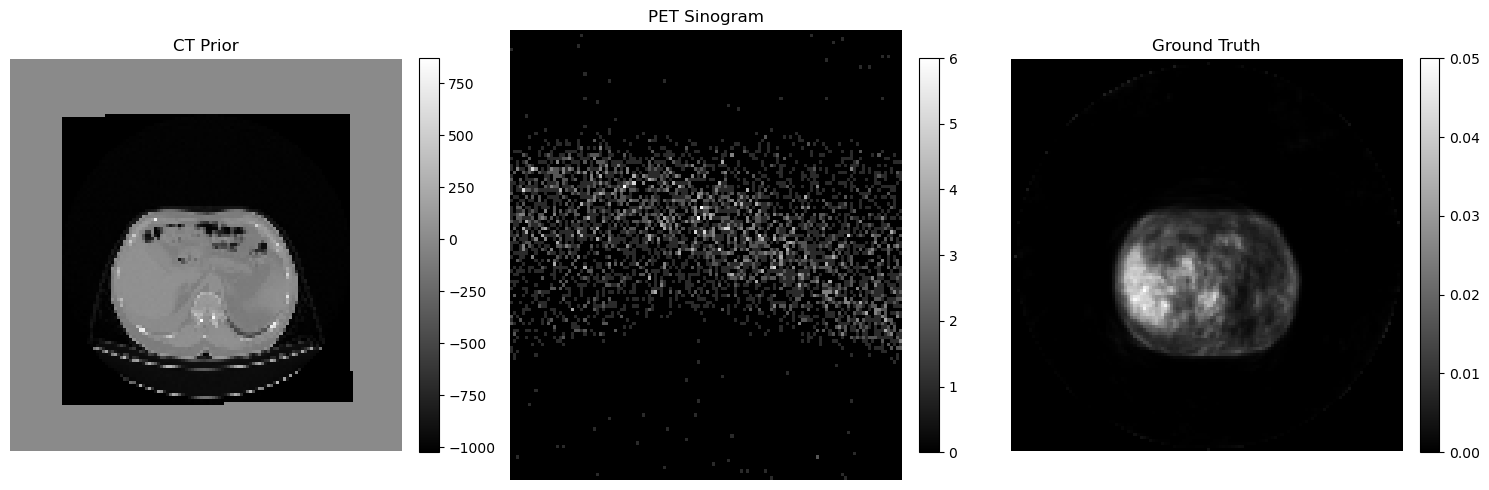

In [42]:
# Plot CT image, PET Image and both sinograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im1 = axes[0].imshow(ct_prior, cmap='gray')
axes[0].set_title("CT Prior")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(pet_sinogram, cmap='gray', aspect='auto')
axes[1].set_title("PET Sinogram")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(ground_truth, cmap='gray')
axes[2].set_title("Ground Truth")
axes[2].axis("off")
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Default values for reconstruction
kernel_size = 5  # Example kernel size for KEM
num_iterations = 10  # Total iterations for the KEM + DIP process
dip_iterations = 100  # Number of iterations for DIP
sigma = 1.0  # Standard deviation for filtering
angles = np.linspace(0., 180., max(ct_prior.shape), endpoint=False)

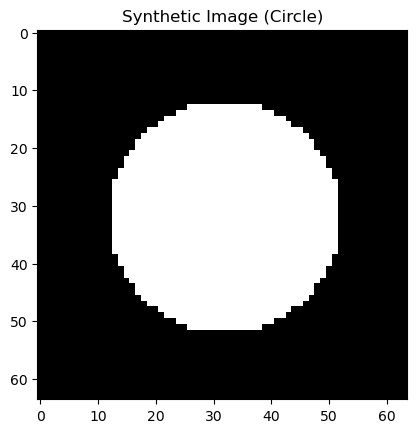

Initial Image Shape: torch.Size([1, 1, 64, 64])
Iteration 1:
  Forward Projection Shape: torch.Size([30, 64])
  Forward Projection Min/Max: 0.0 39.0
  Ratio Min/Max: 0.0 1.0


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [64] and output size of torch.Size([64, 64]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk

# Create a synthetic image: A simple 2D circle
image_size = 64  # Size of the image
image = torch.zeros((1, 1, image_size, image_size), dtype=torch.float32)

# Create a circle in the center of the image
rr, cc = disk((image_size // 2, image_size // 2), radius=20)
image[0, 0, rr, cc] = 1.0

# Plot the image to visualize it
plt.imshow(image[0, 0].cpu().numpy(), cmap='gray')
plt.title("Synthetic Image (Circle)")
plt.show()

# Simulate a simple sinogram using radon transform
angles = np.linspace(0, 180, 30, endpoint=False)  # Simple projection angles
sinogram = np.zeros((len(angles), image_size), dtype=np.float32)

for i, angle in enumerate(angles):
    # Simple projection: simulate a 1D projection of the 2D circle
    sinogram[i, :] = np.sum(image[0, 0].cpu().numpy(), axis=0)  # Sum over rows for simplicity

# Convert sinogram to a torch tensor
sinogram = torch.tensor(sinogram, dtype=torch.float32)

# Define backprojection and projection functions (simplified versions)
def project(image, angles):
    # Simplified projection: just sum over the rows of the image for each angle
    projections = np.zeros((len(angles), image.shape[0]), dtype=np.float32)
    for i, angle in enumerate(angles):
        projections[i, :] = np.sum(image, axis=0)  # Simplified projection along the rows
    return projections

def backproject(sinogram, angles):
    # Simplified backprojection: just average along the rows for simplicity
    return np.mean(sinogram, axis=0)

# Define a dummy filter function (identity filter for simplicity)
def apply_filter(image, method="bilateral", sigma=1.0, ct_prior=None):
    return image

# Run the KEM process with the synthetic image and sinogram
def KEM_process_debug(image, sinogram, angles, kernel_size, sigma=1.0, filter_method="bilateral", ct_prior=None, num_em_iterations=5):
    device = image.device
    updated_image = image.clone()

    print("Initial Image Shape:", updated_image.shape)
    for i in range(num_em_iterations):
        print(f"Iteration {i+1}:")
        
        # Step 1: Forward projection
        forward_projection = project(updated_image.squeeze().detach().cpu().numpy(), angles)
        forward_projection = torch.tensor(forward_projection, dtype=torch.float32).to(device)
        
        # Ensure forward_projection matches sinogram shape
        if forward_projection.shape != sinogram.shape:
            forward_projection = torch.nn.functional.interpolate(
                forward_projection.unsqueeze(0).unsqueeze(0),
                size=sinogram.shape,
                mode="bilinear",
                align_corners=False
            ).squeeze()
        
        print("  Forward Projection Shape:", forward_projection.shape)
        print("  Forward Projection Min/Max:", forward_projection.min().item(), forward_projection.max().item())

        # Step 2: Compute ratio
        ratio = sinogram / (forward_projection + 1e-8)
        ratio = ratio.clamp(min=0, max=10)  # Prevent extreme values
        print("  Ratio Min/Max:", ratio.min().item(), ratio.max().item())
        
        # Step 3: Backproject ratio update
        back_projection = backproject(ratio.cpu().numpy(), angles)
        back_projection = torch.tensor(back_projection, dtype=torch.float32).to(device)
        
        # Ensure back_projection matches image shape
        if back_projection.ndimension() == 1:  # If 1D tensor, reshape to match 2D image
            back_projection = back_projection.unsqueeze(0).unsqueeze(0)
        
        if back_projection.shape[2:] != updated_image.shape[2:]:
            back_projection = torch.nn.functional.interpolate(
                back_projection,
                size=updated_image.shape[2:],
                mode="bilinear",
                align_corners=False
            ).squeeze()
        
        print("  Backprojection Min/Max:", back_projection.min().item(), back_projection.max().item())

        # Step 4: Apply filtering
        smoothed_image = apply_filter(updated_image.squeeze(), method=filter_method, sigma=sigma, ct_prior=ct_prior)
        print("  Filtered Image Min/Max:", smoothed_image.min().item(), smoothed_image.max().item())
        
        # Step 5: Update estimate
        updated_image = smoothed_image * back_projection
        updated_image = updated_image / (updated_image.max() + 1e-8)
        print("  Updated Image Min/Max:", updated_image.min().item(), updated_image.max().item())
        print("--------------------------------")
    
    return updated_image.unsqueeze(0).unsqueeze(0)

# Run KEM process with the synthetic image and sinogram
updated_image = KEM_process_debug(image, sinogram, angles, kernel_size=5)

# Plot the resulting updated image
plt.imshow(updated_image[0, 0].cpu().detach().numpy(), cmap='gray')
plt.title("Updated Image after KEM Process")
plt.show()


c:\ProgramData\Anaconda3\envs\recon\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


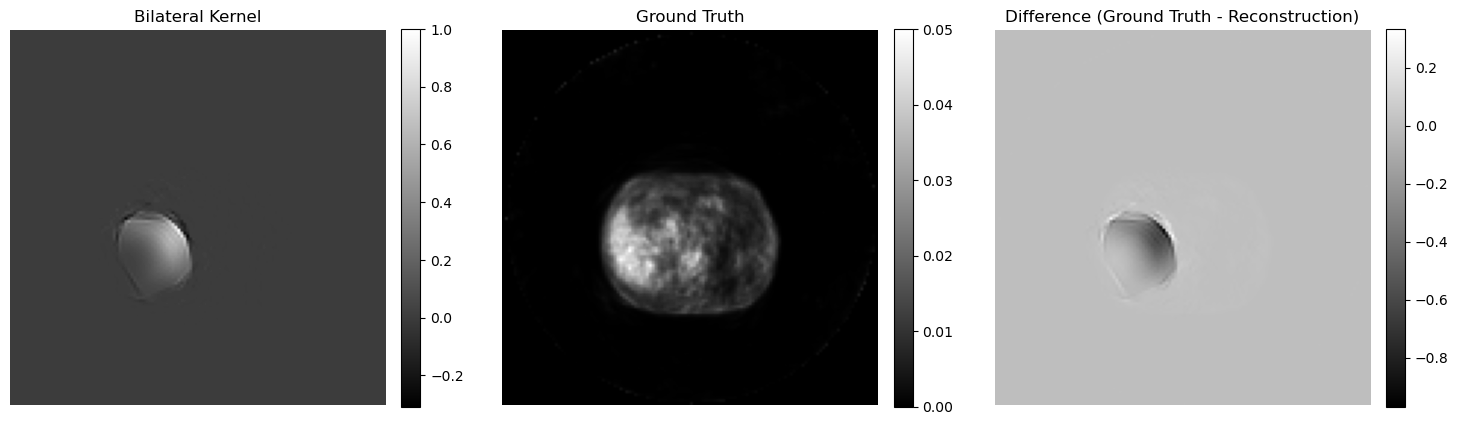

In [44]:
final_image_bilateral = DIP_to_KEM(
    sinogram=torch.tensor(pet_sinogram, dtype=torch.float32),
    angles=angles,
    ct_prior=torch.tensor(ct_prior, dtype=torch.float32),
    kernel_size=kernel_size,
    num_iterations=num_iterations,
    dip_iterations=dip_iterations,
    sigma=sigma,
    filter="bilateral",
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im1 = axes[0].imshow(final_image_bilateral, cmap='gray') 
axes[0].set_title("Bilateral Kernel")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

im3 = axes[2].imshow(ground_truth-final_image_bilateral, cmap='gray')
axes[2].set_title("Difference (Ground Truth - Reconstruction)")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
plt.show()

In [45]:
final_image_gaussian = DIP_to_KEM(
    sinogram=torch.tensor(pet_sinogram, dtype=torch.float32),
    angles=angles,
    ct_prior=torch.tensor(ct_prior, dtype=torch.float32),
    kernel_size=kernel_size,
    num_iterations=num_iterations,
    dip_iterations=dip_iterations,
    sigma=sigma,
    filter="gaussian"
)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im1 = axes[0].imshow(final_image_gaussian, cmap='gray') 
axes[0].set_title("Gaussian Kernel")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

im3 = axes[2].imshow(ground_truth-final_image_gaussian, cmap='gray')
axes[2].set_title("Difference (Ground Truth - Reconstruction)")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
plt.show()

KeyboardInterrupt: 

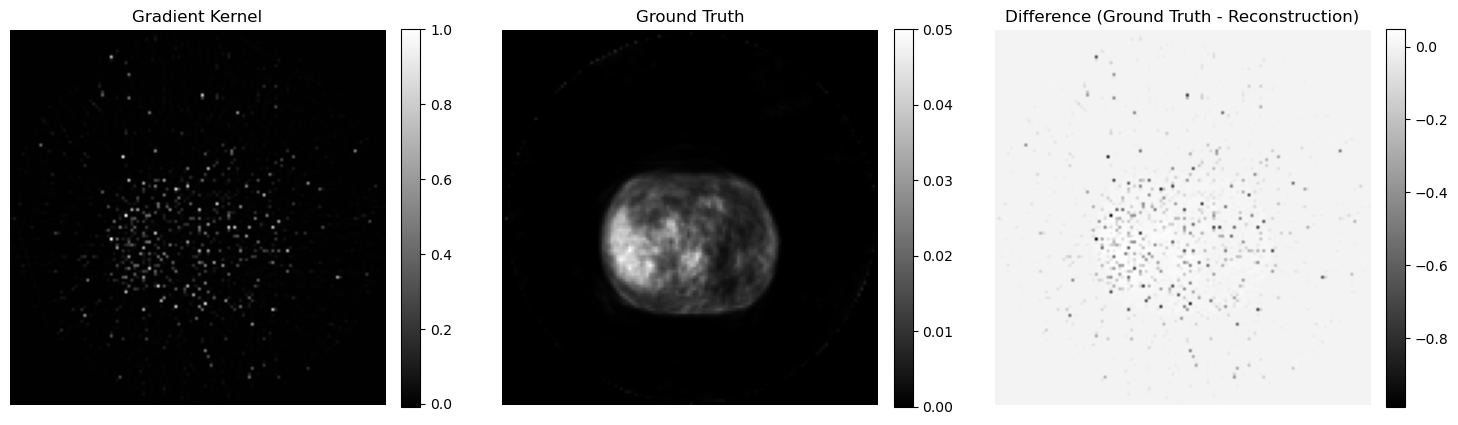

In [ ]:
final_image_gradient = DIP_to_KEM(
    sinogram=torch.tensor(pet_sinogram, dtype=torch.float32),
    angles=angles,
    ct_prior=torch.tensor(ct_prior, dtype=torch.float32),
    kernel_size=kernel_size,
    num_iterations=num_iterations,
    dip_iterations=dip_iterations,
    sigma=sigma,
    filter="gradient"
)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im1 = axes[0].imshow(final_image_gradient, cmap='gray') 
axes[0].set_title("Gradient Kernel")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

im3 = axes[2].imshow(ground_truth-final_image_gradient, cmap='gray')
axes[2].set_title("Difference (Ground Truth - Reconstruction)")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
plt.show()



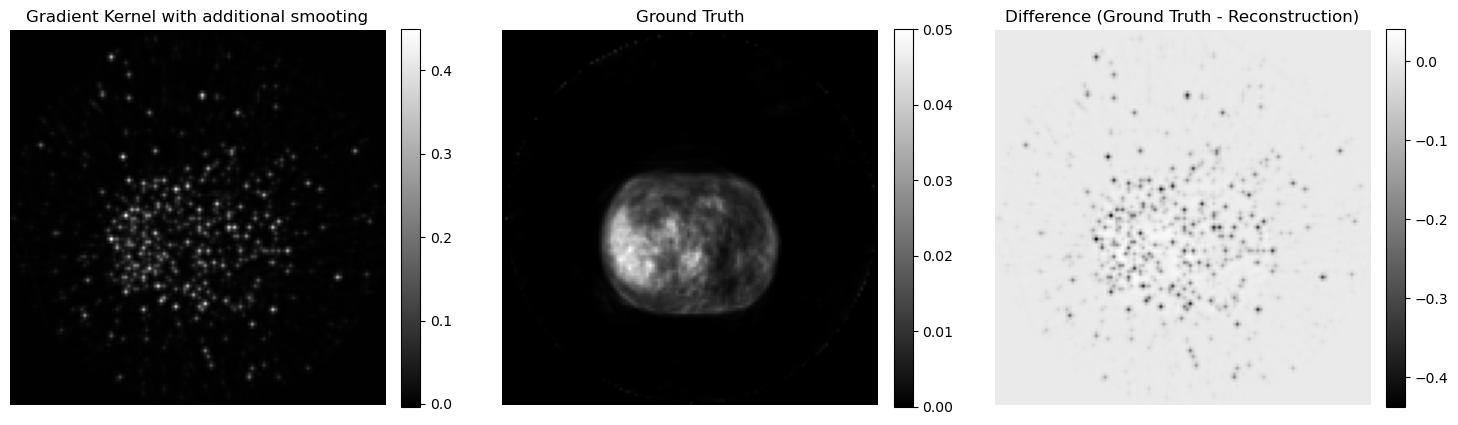

In [ ]:
gradient_smoothed = gaussian_filter(final_image_gradient, sigma=0.6)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im1 = axes[0].imshow(gradient_smoothed, cmap='gray')
axes[0].set_title("Gradient Kernel with additional smooting")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(ground_truth-gradient_smoothed, cmap='gray')
axes[2].set_title("Difference (Ground Truth - Reconstruction)")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.show()

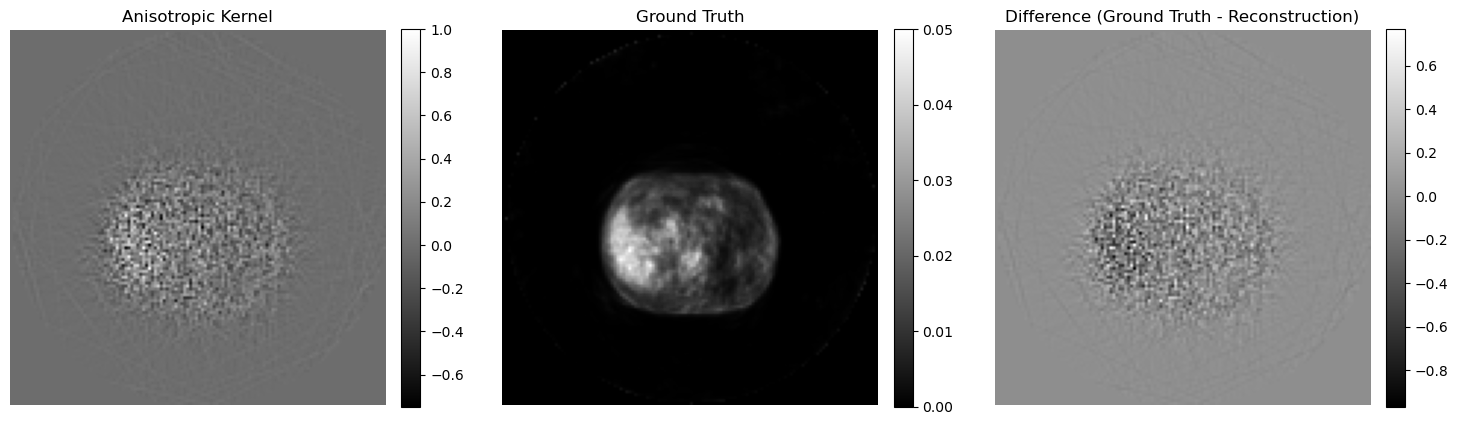

In [ ]:
final_image_anisotropic = DIP_to_KEM(
    sinogram=torch.tensor(pet_sinogram, dtype=torch.float32),
    angles=angles,
    ct_prior=torch.tensor(ct_prior, dtype=torch.float32),
    kernel_size=kernel_size,
    num_iterations=num_iterations,
    dip_iterations=dip_iterations,
    sigma=sigma,
    filter="anisotropic"
)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im1 = axes[0].imshow(final_image_anisotropic, cmap='gray') 
axes[0].set_title("Anisotropic Kernel")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

im3 = axes[2].imshow(ground_truth-final_image_anisotropic, cmap='gray')
axes[2].set_title("Difference (Ground Truth - Reconstruction)")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
plt.show()

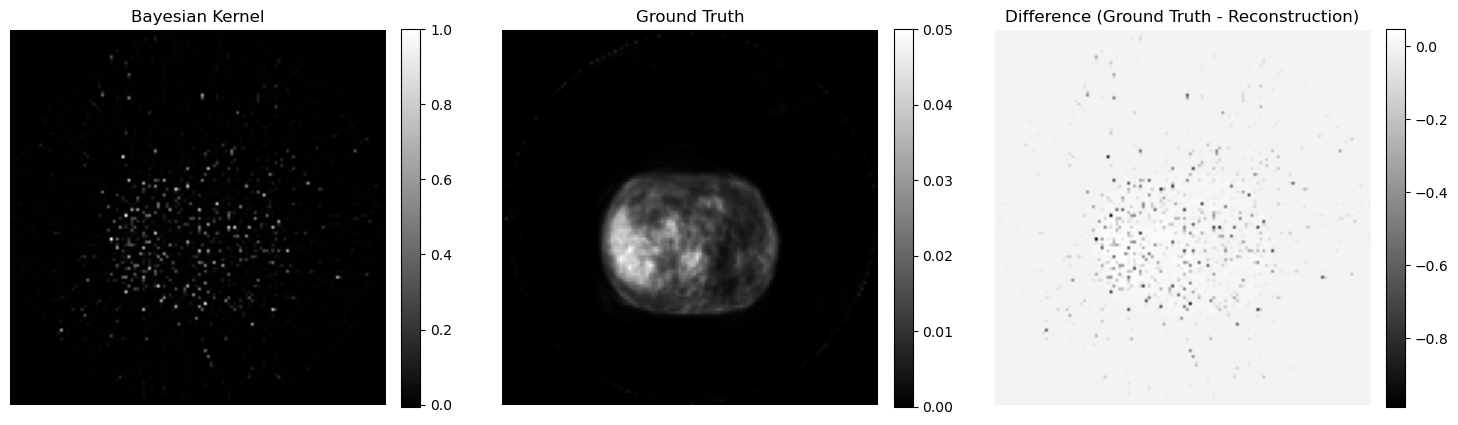

In [ ]:
final_image_bayesian = DIP_to_KEM(
    sinogram=torch.tensor(pet_sinogram, dtype=torch.float32),
    angles=angles,
    ct_prior=torch.tensor(ct_prior, dtype=torch.float32),
    kernel_size=kernel_size,
    num_iterations=num_iterations,
    dip_iterations=dip_iterations,
    sigma=sigma,
    filter="bayesian"
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im1 = axes[0].imshow(final_image_bayesian, cmap='gray') 
axes[0].set_title("Bayesian Kernel")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(ground_truth-final_image_bayesian, cmap='gray')
axes[2].set_title("Difference (Ground Truth - Reconstruction)")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
plt.show()

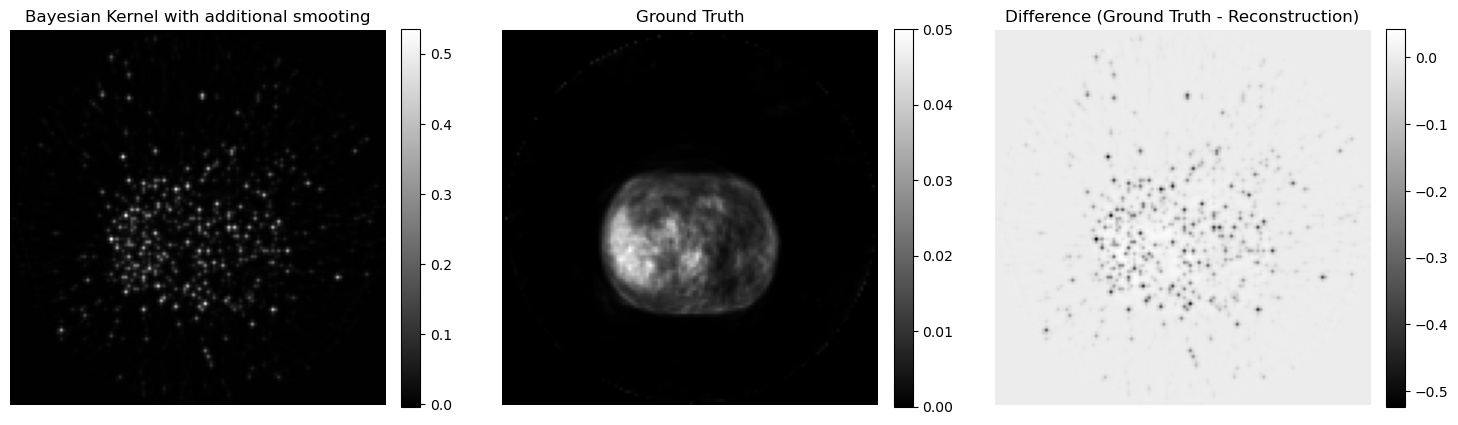

In [ ]:

Bayesian_smoothed = gaussian_filter(final_image_bayesian, sigma=0.55)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im1 = axes[0].imshow(Bayesian_smoothed, cmap='gray')
axes[0].set_title("Bayesian Kernel with additional smooting")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(ground_truth-Bayesian_smoothed, cmap='gray')
axes[2].set_title("Difference (Ground Truth - Reconstruction)")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.show()

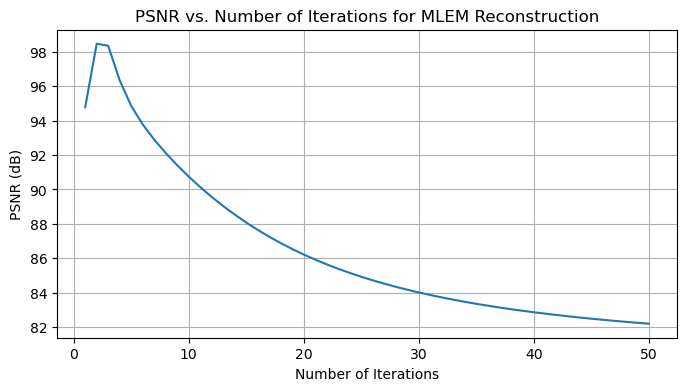

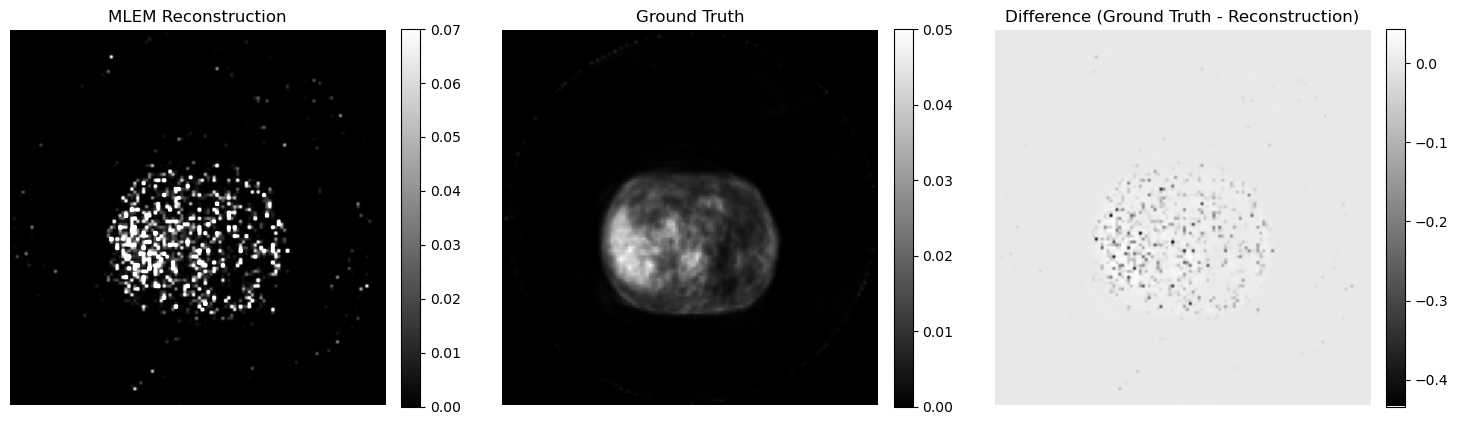

In [ ]:
mlem_reconstructed, psnr_values = MLEM_reconstruction(pet_sinogram, angles, ground_truth, num_iterations=50)
plot_psnr(psnr_values)

#mlem_reconstructed = (mlem_reconstructed - np.min(mlem_reconstructed)) / (np.max(mlem_reconstructed) - np.min(mlem_reconstructed))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  
im1 = axes[0].imshow(mlem_reconstructed, cmap='gray', clim=[0, 0.07])  
axes[0].set_title("MLEM Reconstruction")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04) 
 
im2 = axes[1].imshow(ground_truth, cmap='gray')  
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

im3 = axes[2].imshow(ground_truth-mlem_reconstructed, cmap='gray')
axes[2].set_title("Difference (Ground Truth - Reconstruction)")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.show()


In [ ]:
# Evaluate
metrics_mlem = evaluate_reconstruction(ground_truth, mlem_reconstructed)
metrics_model2_reversed_bilateral = evaluate_reconstruction(ground_truth, final_image_bilateral)
metrics_model2_reversed_anisotropic = evaluate_reconstruction(ground_truth, final_image_anisotropic)
metrics_model2_reversed_gaussian = evaluate_reconstruction(ground_truth, final_image_gaussian)
metrics_model2_reversed_bayesian = evaluate_reconstruction(ground_truth, final_image_bayesian)

# mse_val, psnr_val, ssim_val, rmse_val
print("MLEM:")
print(f"MSE: {metrics_mlem[0]:.4f}, PSNR: {metrics_mlem[1]:.2f}, SSIM: {metrics_mlem[2]:.4f}, RMSE: {metrics_mlem[3]:.4f} \n")


print("Bilateral Kernel:")
print(f"MSE: {metrics_model2_reversed_bilateral[0]:.4f}, PSNR: {metrics_model2_reversed_bilateral[1]:.2f}, SSIM: {metrics_model2_reversed_bilateral[2]:.4f}, RMSE: {metrics_model2_reversed_bilateral[3]:.4f} \n")

print("Anisotropic Kernel:")
print(f"MSE: {metrics_model2_reversed_anisotropic[0]:.4f}, PSNR: {metrics_model2_reversed_anisotropic[1]:.4f}, SSIM: {metrics_model2_reversed_anisotropic[2]:.4f}, RMSE: {metrics_model2_reversed_anisotropic[3]:.4f} \n")

print("Gaussian Kernel:")
print(f"MSE: {metrics_model2_reversed_gaussian[0]:.4f}, PSNR: {metrics_model2_reversed_gaussian[1]:.2f}, SSIM: {metrics_model2_reversed_gaussian[2]:.4f}, RMSE: {metrics_model2_reversed_gaussian[3]:.4f} \n")

print("Bayesian Kernel:")
print(f"MSE: {metrics_model2_reversed_bayesian[0]:.4f}, PSNR: {metrics_model2_reversed_bayesian[1]:.2f}, SSIM: {metrics_model2_reversed_bayesian[2]:.4f}, RMSE: {metrics_model2_reversed_bayesian[3]:.4f} \n")


# SSIM = 1 → Perfect match with the reference image.
# SSIM > 0.9 → Excellent similarity, almost no perceptual difference.
# SSIM 0.7 - 0.9 → Good quality, but noticeable artifacts.
# SSIM 0.5 - 0.7 → Moderate degradation.
# SSIM < 0.5 → Significant structural differences and quality loss.

MLEM:
MSE: 0.0004, PSNR: 82.19, SSIM: 0.6297, RMSE: 0.0198 

Bilateral Kernel:
MSE: 0.0070, PSNR: 69.70, SSIM: 0.1117, RMSE: 0.0835 

Anisotropic Kernel:
MSE: 0.0078, PSNR: 69.2237, SSIM: 0.1097, RMSE: 0.0882 

Gaussian Kernel:
MSE: 0.0042, PSNR: 71.88, SSIM: 0.1250, RMSE: 0.0650 

Bayesian Kernel:
MSE: 0.0025, PSNR: 74.21, SSIM: 0.1518, RMSE: 0.0497 

